In [1]:
# Model Experiments - Features Sets

# Model - Logistic Reg, Log Loss + Elastic Regularisation + SGD
# Features -
#     * All Channels - Raw, Abs, Mag (8)
#     * All Windows  - 0
#     * All Indiv    - nil
#     * All Pairwise -
#            - Synch - Correl, lag-Correl, MI, mimicry, Coherence and Granger's
#            - Convr - Sym.Conv, Asym.Conv, Glob.Conv
#     * All GroupFeat-
#            - Aggreagtion - Min, Max, Mean, Mode, Var
#            
# Evaluation - Acc, Conf.Matrix, AUC, Precision, Recall,

In [2]:
import sys  
sys.path.insert(0, '/Users/navinlr/Desktop/Thesis/code_base/conversation_quality')

In [3]:
from modeling import dataset_provider as data_gen
from feature_extract import turntake_extractor as tt_extractor
import feature_namer_script as feat_namers
import constants

from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, mean_squared_error, roc_auc_score, r2_score, explained_variance_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE, chi2
from lightgbm import LGBMClassifier
from imblearn import under_sampling 
from imblearn import over_sampling
from sklearn.metrics import auc
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scipy import stats
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd
sns.set(rc={'figure.figsize':(11.7,8.27)})

Total Groups = 115


/Users/navinlr/opt/anaconda3/envs/conversation_quality/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/navinlr/opt/anaconda3/envs/conversation_quality/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew inst

In [22]:
# Variables for baseline
random_seed=44
manifest="indiv"
data_split_per=.40
missing_data_thresh=50.0 #(in percent)
convq_thresh=3.0
agreeability_thresh=.2
annotators=["Divya", "Nakul"]#, "Swathi"]
only_involved_pairs=True
use_tt_features=False
splits = 5
store_file=constants.indiv_tt_X_path
if manifest=="group":
    smote_nn = 2
else:
    smote_nn = 6

label_type = "hard"
model_type = "log-elastic"
feat_sel = "anova"
zero_mean  = False

datasets=[constants.features_dataset_path_v7]
dataset_feat=[feat_namers.get_feature_names_for_dataset_7]

In [23]:
# Functions 
def over_sample_data(temp_X, temp_y, method="SMOTE", k_neighbors=6):
    if method == "SMOTE":
        temp_X, temp_y = SMOTE(k_neighbors=k_neighbors-1, random_state=random_seed).fit_resample(temp_X, temp_y)
    return temp_X, temp_y

def feature_normalize(temp_X, method="min-max"):
    # Fit on training set only.
    if method == "min-max":
        normaliser = MinMaxScaler().fit(temp_X)
    elif method == "mean-var":
        normaliser = StandardScaler().fit(temp_X)
    return normaliser
    
def feature_selection(temp_X, temp_y, method="anova", num_feats=None):
    top_features = []
    if method == "anova":
        f_values, p_values = f_classif(temp_X, temp_y)
        threshold=np.median(np.absolute(np.array(f_values)))*num_feats
        top_features=np.where(np.absolute(np.array(f_values)) >= threshold)[0]
#         top_features=np.where(np.absolute(np.array(p_values)) <= 0.5)[0]
    elif method == "tree-based":
        sel_model = SelectFromModel(RandomForestClassifier(n_estimators=100, class_weight='balanced'),
                                    max_features=num_feats, threshold=-np.inf).fit(temp_X, temp_y)
        top_features = sel_model.get_support(True)
    elif method == "rec-elim":
        sel_model = RFE(estimator=LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced'),
                        n_features_to_select=num_feats, step=10000).fit(temp_X, temp_y)
        top_features = sel_model.get_support(True)
    elif method == "lgbc":
        lgbc = LGBMClassifier(n_estimators=1000, learning_rate=0.05)
        sel_model = SelectFromModel(lgbc, max_features=num_feats, threshold=-np.inf).fit(temp_X, temp_y)
        top_features = sel_model.get_support(True)

    return top_features

def select_required_features(temp_X, required_feats, method="anova"):
    if method == "anova":
        temp_X=temp_X[:,required_feats]
#     elif method
    return temp_X

def dimension_reduction(temp_X, method="pca", threshold_var=0.95):
    dim_red_model = None
    if method=="pca":
        dim_red_model = PCA(threshold_var).fit(temp_X)
    elif method=="tsne":
        dim_red_model = TSNE(n_components=2).fit(temp_X)
    return dim_red_model
    
def process_convq_labels(y, label_type="soft"):
    print("Data-type of labels - " + str(type(y)))
    if label_type=="soft":
        y=list(np.around(np.array(y),2))
    else:
        y=list(np.where(np.array(y) <= convq_thresh, 0, 1))
        print("ConvQ Classes Distribution : (Total = "+ str(len(y)) +")")
        print("High Quality Conv = " + str(sum(y)))
        print("Low Quality Conv = " + str(len(y)-sum(y)))
    return y

def model_convq_manifestation(temp_X, temp_y, model="log-reg", fit=True):
    
    if fit:
        if model == "log-reg":
            model = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced').fit(temp_X, temp_y)
        elif model == "lin-reg":
            model = LinearRegression().fit(temp_X, temp_y)
        elif model == "adaboost":
            model = AdaBoostClassifier(n_estimators=500).fit(temp_X, temp_y)
        elif model == "dec-tree":
            model = DecisionTreeClassifier(class_weight='balanced').fit(temp_X, temp_y)
        elif model == "rand-for":
            model = RandomForestClassifier(n_estimators=1000, class_weight='balanced').fit(temp_X, temp_y)
        elif model == "svm":
            model = SVC(kernel='poly').fit(temp_X, temp_y)
        elif model == "log-elastic":
            model = SGDClassifier(loss="log", class_weight="balanced", penalty="elasticnet",
                                  learning_rate='adaptive', eta0=0.001,
                                  max_iter=10000).fit(temp_X, temp_y)
        elif model == "grad-boost-quant":
            model = GradientBoostingRegressor(loss='quantile',n_estimators=1000).fit(temp_X, temp_y)
    else:
        if model == "log-reg":
            model = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced')
        elif model == "lin-reg":
            model = LinearRegression()
        elif model == "adaboost":
            model = AdaBoostClassifier(n_estimators=500)
        elif model == "dec-tree":
            model = DecisionTreeClassifier(class_weight='balanced')
        elif model == "rand-for":
            model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
        elif model == "svm":
            model = SVC(kernel='poly')
        elif model == "log-elastic":
            model = SGDClassifier(loss="log", max_iter=10000, class_weight='balanced')
        elif model == "grad-boost-quant":
            model = GradientBoostingRegressor(loss='quantile',n_estimators=1000)
    return model

def get_model_predict_proba(temp_X, model):
    return model.predict_proba(temp_X)[::,1]

def analyse_model_params(model):
    return True

def test_model(temp_X, model):
    return model.predict(temp_X)

def evaluate_predict(test_temp_y, predict_temp_y, method=accuracy_score):
    score = method(test_temp_y, predict_temp_y)
    return score

In [24]:
# Experiment List
experiments=["Minimum",
             "Maximum", 
             "Mean",
             "Variance",
             "Minimum +\n Maximum +\n Mean +\n Variance",
             "Mode",
             "Median", 
             "Fusion"]

In [25]:
# Data Read
auc_experiment_dict={}
X=[]
feat_namer=[]
for w, curr_dataset in enumerate(datasets):

    curr_X, y, ids = data_gen.get_dataset_for_experiment(dataset=curr_dataset,
                                                        manifest=manifest,
                                                        missing_data_thresh=missing_data_thresh,
                                                        agreeability_thresh=agreeability_thresh,
                                                        annotators=annotators,
                                                        only_involved_pairs=only_involved_pairs,
                                                        zero_mean=zero_mean)
    
    if len(X) == 0:
        X=curr_X
        feat_namer=dataset_feat[w]()
    else:
        X=np.concatenate((X, curr_X), axis=1) 
        feat_namer.extend(dataset_feat[w]())
        
    print("Current Feature Set - " + str(X.shape))
# Label Prep
# Hard/Soft Labels
y = process_convq_labels(y, label_type)

features_df=pd.DataFrame(np.array(X), columns=feat_namer)

Generating Dataset for modeling - indiv ConvQ, ...........
Number of Groups (After removing missing data) - 85
ZERO-MEAN Technique ? - False
ZERO-MEAN Technique ? - False


34it [00:00, 174.92it/s]

Number of Final Data-points (After removing unreliable annotation data) - 179


179it [00:01, 142.99it/s]

Total #Features = 756
Current Feature Set - (179, 756)
Data-type of labels - <class 'list'>
ConvQ Classes Distribution : (Total = 179)
High Quality Conv = 163
Low Quality Conv = 16


In [26]:
# Min Gather
min_feats=[]
for f in feat_namer:
    if "--min" in f:
        min_feats.extend([f])

# Max Gather
max_feats=[]
for f in feat_namer:
    if "--max" in f:
        max_feats.extend([f])

# Mean Gather
mean_feats=[]
for f in feat_namer:
    if "--mean" in f:
        mean_feats.extend([f])

#Variance Gather
var_feats=[]
for f in feat_namer:
    if "--var" in f:
        var_feats.extend([f])
        
# Min Max Mean Variance Gather   
min_max_mean_var_feats=list(min_feats)   
min_max_mean_var_feats.extend(max_feats)
min_max_mean_var_feats.extend(mean_feats)
min_max_mean_var_feats.extend(var_feats)


# Mode Gather
mode_feats=[]
for f in feat_namer:
    if "--mode" in f:
        mode_feats.extend([f])
        
# Median Gather
median_feats=[]
for f in feat_namer:
    if "--median" in f:
        median_feats.extend([f])
        
# ALL Fuse
fuse_feats=list(min_max_mean_var_feats)
fuse_feats.extend(mode_feats)
fuse_feats.extend(median_feats)

print("Number of Min Features = " + str(len(min_feats)))
print("Number of Max Features = " + str(len(max_feats)))
print("Number of Mean Features = " + str(len(mean_feats)))
print("Number of Variance Features = " + str(len(var_feats)))
print("Number of MMMV Features = " + str(len(min_max_mean_var_feats)))
print("Number of Mode Features = " + str(len(mode_feats)))
print("Number of Median Features = " + str(len(median_feats)))

print("Number of Fusion = " + str(len(fuse_feats)))

print(len(feat_namer))

feat_stack=[min_feats,
            max_feats,
            mean_feats,
            var_feats,
            min_max_mean_var_feats,
            mode_feats,
            median_feats,
            fuse_feats]


print(len(feat_stack))
print(len(experiments))

Number of Min Features = 126
Number of Max Features = 126
Number of Mean Features = 126
Number of Variance Features = 126
Number of MMMV Features = 504
Number of Mode Features = 126
Number of Median Features = 126
Number of Fusion = 756
756
8
8




~~ !! @@ @@ @@ @@ Current Feature-Set = Minimum ~~ !! @@ @@ @@ @@
After PCA Feature Set - (143, 43)
After anova Feature Set - (143, 27)
Train Data -> Features - (260, 27) and Labels - 260
Test  Data -> Features - (36, 27) and Labels - 36
130
After PCA Feature Set - (143, 43)
After anova Feature Set - (143, 29)
Train Data -> Features - (260, 29) and Labels - 260
Test  Data -> Features - (36, 29) and Labels - 36
130
After PCA Feature Set - (143, 43)
After anova Feature Set - (143, 30)
Train Data -> Features - (260, 30) and Labels - 260
Test  Data -> Features - (36, 30) and Labels - 36
130
After PCA Feature Set - (143, 43)
After anova Feature Set - (143, 27)
Train Data -> Features - (262, 27) and Labels - 262
Test  Data -> Features - (36, 27) and Labels - 36
131
After PCA Feature Set - (144, 42)
After anova Feature Set - (144, 27)
Train Data -> Features - (262, 27) and Labels - 262
Test  Data -> Features - (35, 27) and Labels - 35
131


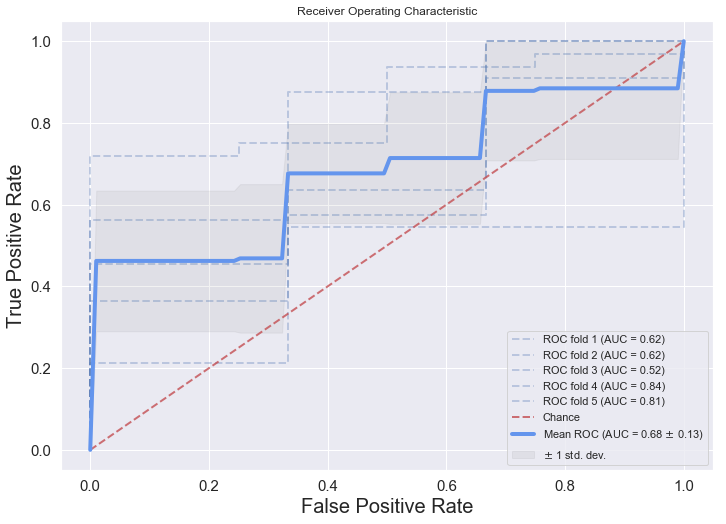

[0.6161616161616161, 0.6161616161616161, 0.5151515151515151, 0.84375, 0.8125]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[  6  10]
 [ 33 130]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Maximum ~~ !! @@ @@ @@ @@
After PCA Feature Set - (143, 43)
After anova Feature Set - (143, 10)
Train Data -> Features - (260, 10) and Labels - 260
Test  Data -> Features - (36, 10) and Labels - 36
130
After PCA Feature Set - (143, 42)
After anova Feature Set - (143, 14)
Train Data -> Features - (260, 14) and Labels - 260
Test  Data -> Features - (36, 14) and Labels - 36
130
After PCA Feature Set - (143, 43)
After anova Feature Set - (143, 10)
Train Data -> Features - (260, 10) and Labels - 260
Test  Data -> Features - (36, 10) and Labels - 36
130
After PCA Feature Set - (143, 43)
After anova Feature Set - (143, 12)
Train Data -> Features - (262, 12) and Labels - 262
Test  Data -> Features - (36, 12) and Labels - 36
131
After PCA Feature Set - (144, 43)
After anova Feature Set - (144, 13)
Train Data -> Fe

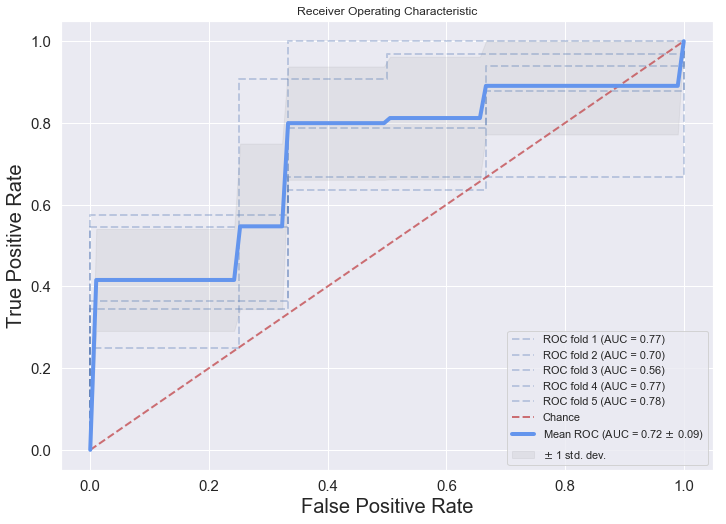

[0.7676767676767677, 0.6969696969696969, 0.5555555555555556, 0.7734375, 0.7812500000000001]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[ 10   6]
 [ 44 119]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Mean ~~ !! @@ @@ @@ @@
After PCA Feature Set - (143, 42)
After anova Feature Set - (143, 14)
Train Data -> Features - (260, 14) and Labels - 260
Test  Data -> Features - (36, 14) and Labels - 36
130
After PCA Feature Set - (143, 40)
After anova Feature Set - (143, 11)
Train Data -> Features - (260, 11) and Labels - 260
Test  Data -> Features - (36, 11) and Labels - 36
130
After PCA Feature Set - (143, 42)
After anova Feature Set - (143, 10)
Train Data -> Features - (260, 10) and Labels - 260
Test  Data -> Features - (36, 10) and Labels - 36
130
After PCA Feature Set - (143, 41)
After anova Feature Set - (143, 6)
Train Data -> Features - (262, 6) and Labels - 262
Test  Data -> Features - (36, 6) and Labels - 36
131
After PCA Feature Set - (144, 41)
After anova Feature Set - (144, 10)
Train Da

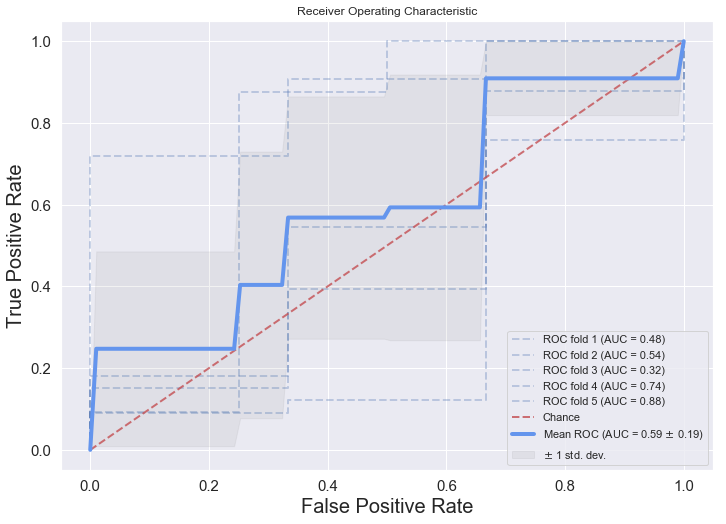

[0.48484848484848486, 0.5353535353535355, 0.3232323232323232, 0.7421875, 0.875]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[  9   7]
 [ 57 106]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Variance ~~ !! @@ @@ @@ @@
After PCA Feature Set - (143, 37)
After anova Feature Set - (143, 26)
Train Data -> Features - (260, 26) and Labels - 260
Test  Data -> Features - (36, 26) and Labels - 36
130
After PCA Feature Set - (143, 41)
After anova Feature Set - (143, 26)
Train Data -> Features - (260, 26) and Labels - 260
Test  Data -> Features - (36, 26) and Labels - 36
130
After PCA Feature Set - (143, 37)
After anova Feature Set - (143, 21)
Train Data -> Features - (260, 21) and Labels - 260
Test  Data -> Features - (36, 21) and Labels - 36
130
After PCA Feature Set - (143, 37)
After anova Feature Set - (143, 26)
Train Data -> Features - (262, 26) and Labels - 262
Test  Data -> Features - (36, 26) and Labels - 36
131
After PCA Feature Set - (144, 38)
After anova Feature Set - (144, 21)
Train Data ->

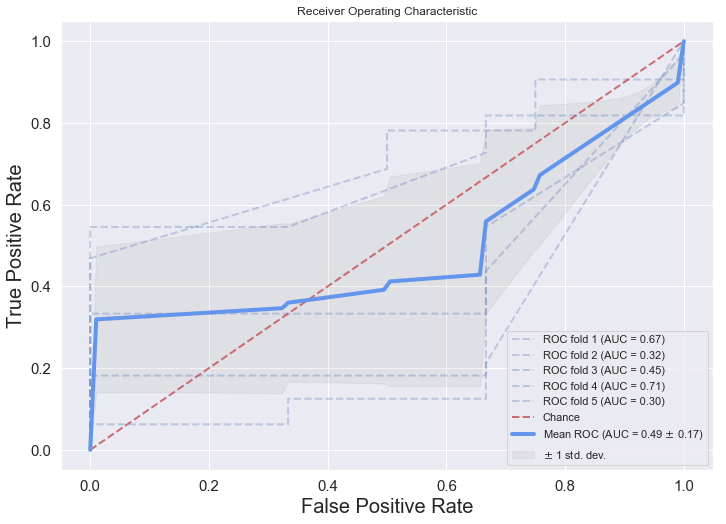

[0.6666666666666667, 0.32323232323232326, 0.4545454545454546, 0.7109375, 0.296875]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[ 6 10]
 [75 88]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Minimum +
 Maximum +
 Mean +
 Variance ~~ !! @@ @@ @@ @@
After PCA Feature Set - (143, 64)
After anova Feature Set - (143, 11)
Train Data -> Features - (260, 11) and Labels - 260
Test  Data -> Features - (36, 11) and Labels - 36
130
After PCA Feature Set - (143, 64)
After anova Feature Set - (143, 16)
Train Data -> Features - (260, 16) and Labels - 260
Test  Data -> Features - (36, 16) and Labels - 36
130
After PCA Feature Set - (143, 63)
After anova Feature Set - (143, 10)
Train Data -> Features - (260, 10) and Labels - 260
Test  Data -> Features - (36, 10) and Labels - 36
130
After PCA Feature Set - (143, 63)
After anova Feature Set - (143, 21)
Train Data -> Features - (262, 21) and Labels - 262
Test  Data -> Features - (36, 21) and Labels - 36
131
After PCA Feature Set - (144, 64)
After anova Feature 

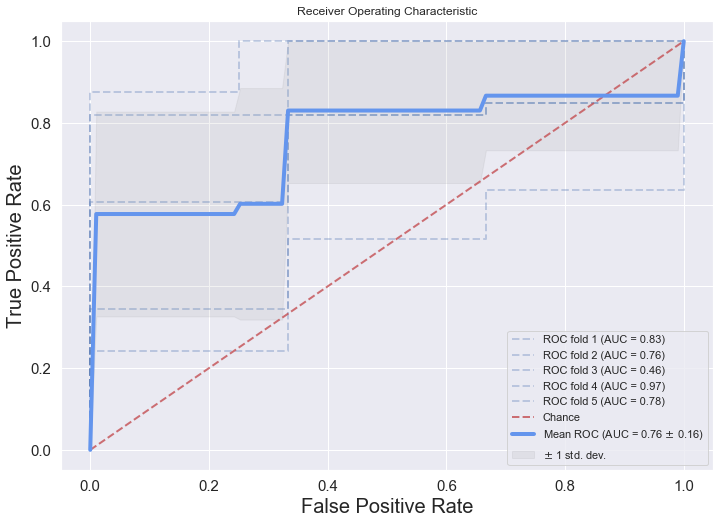

[0.8282828282828283, 0.7575757575757576, 0.46464646464646464, 0.96875, 0.7812500000000001]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[  7   9]
 [ 32 131]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Mode ~~ !! @@ @@ @@ @@
After PCA Feature Set - (143, 43)
After anova Feature Set - (143, 10)
Train Data -> Features - (260, 10) and Labels - 260
Test  Data -> Features - (36, 10) and Labels - 36
130
After PCA Feature Set - (143, 43)
After anova Feature Set - (143, 6)
Train Data -> Features - (260, 6) and Labels - 260
Test  Data -> Features - (36, 6) and Labels - 36
130
After PCA Feature Set - (143, 43)
After anova Feature Set - (143, 9)
Train Data -> Features - (260, 9) and Labels - 260
Test  Data -> Features - (36, 9) and Labels - 36
130
After PCA Feature Set - (143, 43)
After anova Feature Set - (143, 8)
Train Data -> Features - (262, 8) and Labels - 262
Test  Data -> Features - (36, 8) and Labels - 36
131
After PCA Feature Set - (144, 42)
After anova Feature Set - (144, 8)
Train Data -> Fe

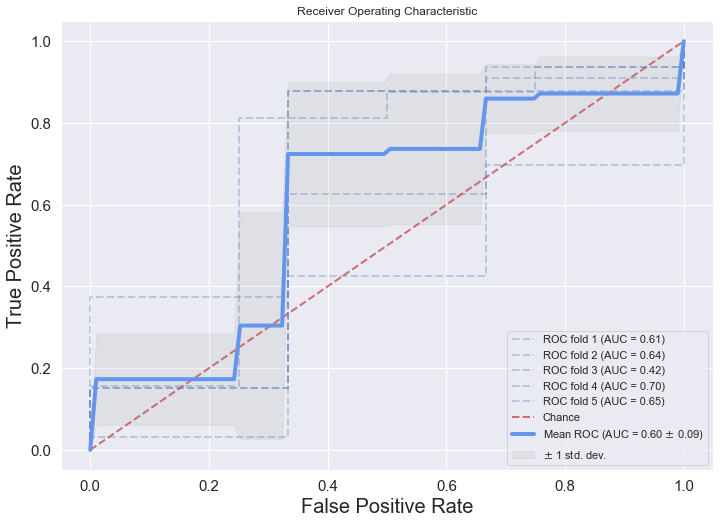

[0.6060606060606061, 0.6363636363636365, 0.4242424242424243, 0.6953125, 0.6458333333333334]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[  9   7]
 [ 49 114]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Median ~~ !! @@ @@ @@ @@
After PCA Feature Set - (143, 44)
After anova Feature Set - (143, 10)
Train Data -> Features - (260, 10) and Labels - 260
Test  Data -> Features - (36, 10) and Labels - 36
130
After PCA Feature Set - (143, 42)
After anova Feature Set - (143, 9)
Train Data -> Features - (260, 9) and Labels - 260
Test  Data -> Features - (36, 9) and Labels - 36
130
After PCA Feature Set - (143, 43)
After anova Feature Set - (143, 12)
Train Data -> Features - (260, 12) and Labels - 260
Test  Data -> Features - (36, 12) and Labels - 36
130
After PCA Feature Set - (143, 43)
After anova Feature Set - (143, 8)
Train Data -> Features - (262, 8) and Labels - 262
Test  Data -> Features - (36, 8) and Labels - 36
131
After PCA Feature Set - (144, 43)
After anova Feature Set - (144, 11)
Train Dat

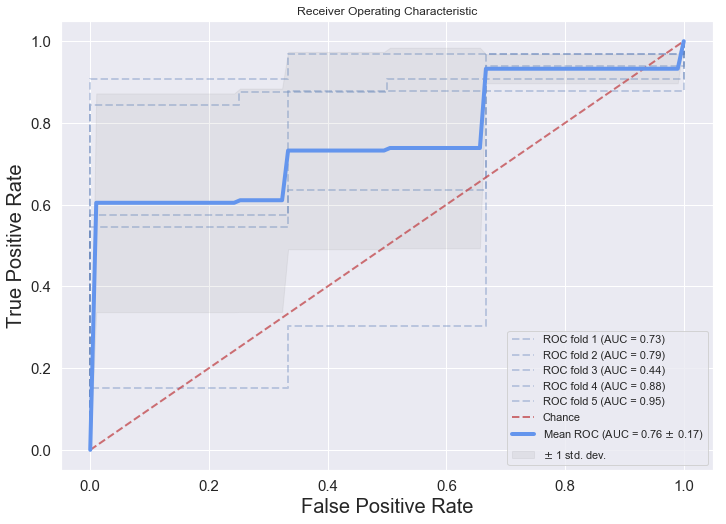

[0.7272727272727273, 0.787878787878788, 0.4444444444444445, 0.8828125, 0.9479166666666667]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[ 12   4]
 [ 40 123]]


~~ !! @@ @@ @@ @@ Current Feature-Set = Fusion ~~ !! @@ @@ @@ @@
After PCA Feature Set - (143, 63)
After anova Feature Set - (143, 13)
Train Data -> Features - (260, 13) and Labels - 260
Test  Data -> Features - (36, 13) and Labels - 36
130
After PCA Feature Set - (143, 64)
After anova Feature Set - (143, 12)
Train Data -> Features - (260, 12) and Labels - 260
Test  Data -> Features - (36, 12) and Labels - 36
130
After PCA Feature Set - (143, 62)
After anova Feature Set - (143, 16)
Train Data -> Features - (260, 16) and Labels - 260
Test  Data -> Features - (36, 16) and Labels - 36
130
After PCA Feature Set - (143, 63)
After anova Feature Set - (143, 13)
Train Data -> Features - (262, 13) and Labels - 262
Test  Data -> Features - (36, 13) and Labels - 36
131
After PCA Feature Set - (144, 63)
After anova Feature Set - (144, 11)
Trai

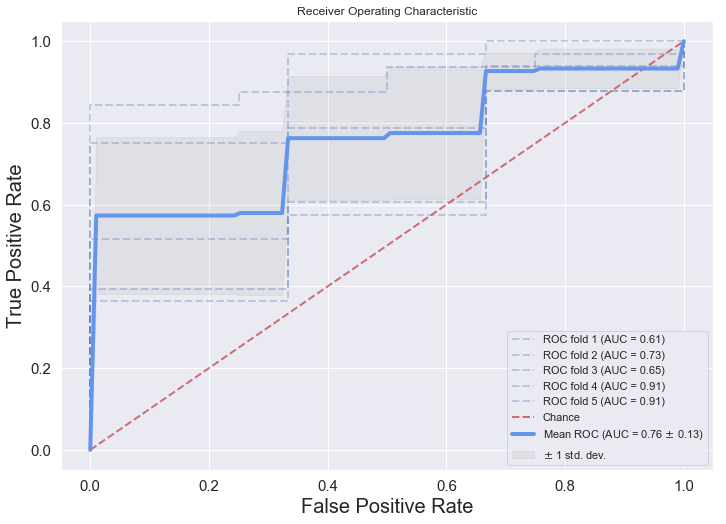

[0.6060606060606062, 0.7272727272727273, 0.6464646464646465, 0.90625, 0.90625]
~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~
[[  9   7]
 [ 31 132]]


In [27]:
feat_sel_threshold=[0.5, 3, 3, 0.5, 3, 3, 3, 3]
auc_experiment_dict={}

for f, curr_stack in enumerate(feat_stack):
#     print(features_df)
    experiment_feats=curr_stack
    
    print()
    print()
    print("~~ !! @@ @@ @@ @@ Current Feature-Set = " + str(experiments[f]) + " ~~ !! @@ @@ @@ @@")

    final_conf_matrix = [[0,0],[0,0]]
    final_auc_score = 0.0
    final_r_squared = 0.0
    final_expl_vari = 0.0
    iterative_auc = 0.0
    final_predict = []
    final_pred_prob = []
    final_label = []
    cv_auc_scores = []


    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()

    # Setup Features 
    X=features_df.loc[:,experiment_feats].values
    
    skf = StratifiedKFold(n_splits=5)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):

        # Data Prep
        train_X, test_X  = X[train_index], X[test_index]
        train_y, test_y  = [y[i] for i in train_index], [y[i] for i in test_index]

        # Transform Features
        normaliser = feature_normalize(train_X, method="mean-var")
        # Apply transform to both the training set and the test set.
        train_X = normaliser.transform(train_X)
        test_X  = normaliser.transform(test_X)

        # Dimensionality Reduction
        dimension_model = dimension_reduction(train_X, method="pca")
        train_X = dimension_model.transform(train_X)
        test_X  = dimension_model.transform(test_X)

        print("After " + "PCA" + " Feature Set - " + str(train_X.shape))

        # Feature Selection
        top_features = feature_selection(train_X, train_y, method=feat_sel, num_feats=feat_sel_threshold[f])
        train_X = select_required_features(train_X, top_features) 
        test_X  = select_required_features(test_X, top_features) 

        print("After " + feat_sel + " Feature Set - " + str(train_X.shape))


        # SAMPLING
        train_X, train_y = over_sample_data(train_X, train_y, method="SMOTE", k_neighbors=smote_nn)

        print("Train Data -> Features - " + str(train_X.shape) + " and Labels - " + str(len(train_y)))
        print("Test  Data -> Features - " + str(test_X.shape) + " and Labels - " + str(len(test_y)))
        print(str(sum(train_y))) 

        # Modelling
        classifier         = model_convq_manifestation(train_X, train_y, model_type, fit=True)        
        predict_y          = test_model(test_X, classifier) 


        final_conf_matrix = final_conf_matrix + evaluate_predict(test_y, predict_y, confusion_matrix)

        # CV ROC Plot
        viz = plot_roc_curve(classifier, test_X, test_y,
                         name='ROC fold {}'.format(i+1),
                         alpha=0.3, lw=2, linestyle='--', color='b', ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='cornflowerblue',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=4, alpha=1.0)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.1,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.tick_params(labelsize=15)
    
    plt.show()

    print(aucs)
    auc_experiment_dict[experiments[f]]=aucs
    print("~~~~~~~~~~~ Confusion Matrix ~~~~~~~~~~~")
    print(final_conf_matrix)

In [28]:
all_values=[]
all_keys=[]
print(len(auc_experiment_dict.keys()))
print(len(experiments))
for i, k in enumerate(auc_experiment_dict.keys()):
    val=auc_experiment_dict[k]
#     if i !=0:
#         val=[x+.1 for x in val]
    all_values.extend(val)
    text=experiments[i]

    all_keys.extend([text] * 5)

experiment_results=pd.DataFrame(
    {'values': all_values,
     'type': all_keys
    })

8
8


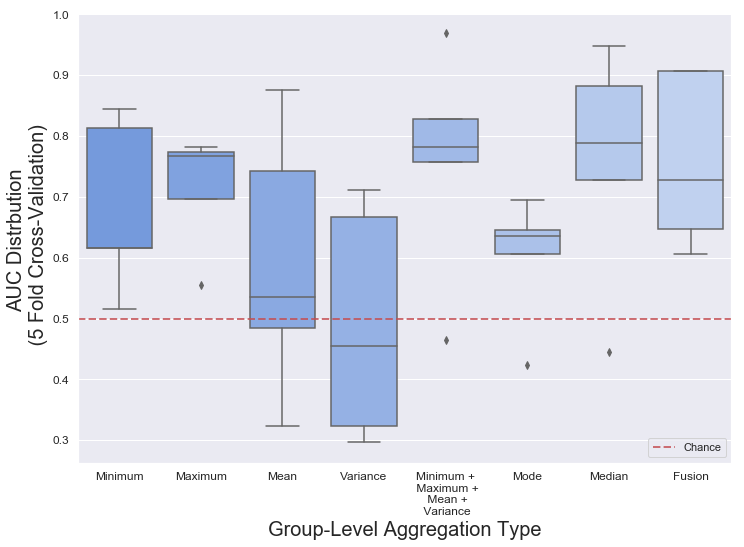

In [29]:
ax = sns.boxplot(x="type", y="values", data=experiment_results, palette=sns.light_palette("cornflowerblue", reverse=True, n_colors=12))

plt.ylabel('AUC Distrbution \n (5 Fold Cross-Validation)', fontsize=20)
plt.xlabel('Group-Level Aggregation Type', fontsize=20)
plt.tick_params(labelsize=12)

# ax.plot(y=0.5, linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

plt.axhline(0.5, linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Might need to loop through the list if there are multiple lines on the plot
# ax.lines[0].set_linestyle("--")
# plt.plot(0.5)
plt.legend(loc="lower right")


plt.show()